    Outlook Temperature Humidity    Wind Play Tennis
0     Sunny         Hot     High    Weak          No
1     Sunny         Hot     High  Strong          No
2  Overcast         Hot     High    Weak         Yes
3      Rain        Mild     High    Weak         Yes
4      Rain        Cool   Normal    Weak         Yes


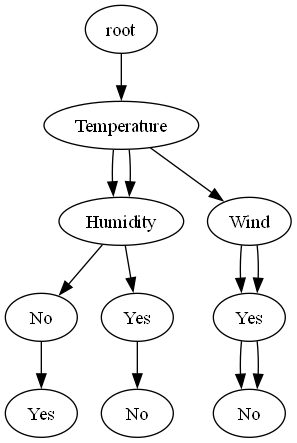

'cart_decision_tree.png'

In [4]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import graphviz
from IPython.display import Image, display

# Load dataset (assumed to be in the same directory as the Jupyter notebook)
df = pd.read_csv('PlayTennis.csv')

# Display the first few rows of the dataset
print(df.head())

# Utility functions
def gini_impurity(labels):
    counts = Counter(labels)
    total = len(labels)
    return 1 - sum((count / total) ** 2 for count in counts.values())

def info_gain_gini(df, attr, target):
    total_gini = gini_impurity(df[target])
    values = df[attr].unique()
    weighted_gini = 0

    for val in values:
        subset = df[df[attr] == val]
        weighted_gini += (len(subset) / len(df)) * gini_impurity(subset[target])

    return total_gini - weighted_gini

# Recursive tree builder for CART
def build_tree_cart(df, target, features):
    labels = df[target]
    
    # Base cases
    if len(set(labels)) == 1:
        return labels.iloc[0]
    if not features:
        return labels.mode()[0]

    best_attr = None
    best_split = None
    best_gini = float('inf')

    # Best attribute selection using Gini index
    for attr in features:
        gini = info_gain_gini(df, attr, target)
        if gini < best_gini:
            best_gini = gini
            best_attr = attr
            best_split = df[best_attr].unique()

    tree = {best_attr: {}}
    for val in best_split:
        sub_df = df[df[best_attr] == val]
        subtree = build_tree_cart(sub_df, target, [f for f in features if f != best_attr])
        tree[best_attr][val] = subtree

    return tree

# Build the CART tree
features = list(df.columns)
features.remove('Play Tennis')  # Corrected column name
decision_tree_cart = build_tree_cart(df, target='Play Tennis', features=features)

# Function to visualize the tree using Graphviz
def visualize_tree_cart(tree, parent_name, graph=None):
    if graph is None:
        graph = graphviz.Digraph(format='png', engine='dot')

    # If the tree is a leaf node (a string, class label)
    if isinstance(tree, str):
        graph.node(parent_name, tree)
        return graph
    
    for key, value in tree.items():
        node_name = f'{parent_name}_{key}'
        graph.node(node_name, key)
        graph.edge(parent_name, node_name)

        if isinstance(value, dict):  # If the value is a dictionary, recurse further
            for sub_key, sub_value in value.items():
                visualize_tree_cart(sub_value, node_name, graph)
        else:  # If the value is a string (leaf node), just display the label
            graph.node(f'{node_name}_{value}', value)
            graph.edge(node_name, f'{node_name}_{value}')

    return graph

# Visualize the decision tree (CART)
graph_cart = visualize_tree_cart(decision_tree_cart, 'root')

# Save the tree as a PNG image
graph_cart.render('cart_decision_tree')  # This saves the tree as 'cart_decision_tree.png'

# Display the image in the Jupyter notebook
display(Image(filename='cart_decision_tree.png'))

# If you'd like to directly view the Graphviz output in the notebook:
graph_cart.view()  # This opens the PNG in a viewer automatically
